# Sprint12 2次元の畳み込みニューラルネットワークスクラッチ

## 【問題1】2次元畳み込み層の作成
---
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

In [25]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
#         self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

def get_mini_batch_data():
    from keras.datasets import mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.reshape(-1, 784)
    X_test = X_test.reshape(-1, 784)

    X_train = X_train.astype(np.float)
    X_test = X_test.astype(np.float)
    X_train /= 255
    X_test /= 255

    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

    # One-hotエンコーダー
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
    y_val_one_hot = enc.transform(y_val[:, np.newaxis])

    print(y_train_one_hot.shape)
    print(y_val_one_hot.shape)

    data = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)


    return data

def cross_entropy_error(y, Z3):
    '''
    交差エントロピー誤差の計算
    '''

    DELTA = 1e-7
    batch_size = y.shape[0]
    return -np.sum(y * np.log(Z3 + DELTA))/batch_size

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(*shape)
        return w

    def B(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        # b = self.sigma * np.random.randn(*shape)
        b = np.zeros(*shape)
        return b

    def B_zeros(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = np.zeros(*shape)
        return b

class Tanh:

    def forward(self, A):
        self.A = A
        return np.tanh(A)

    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)


class Softmax:
    """
    ソフトマックス関数
    Parameters
    ----------

    """
    def __init__(self):
        self.loss = None

    def forward(self, X):

        X = X.T
        y = np.exp(X) / np.sum(np.exp(X), axis=0)

        return y.T

    def backward(self, Z3, y):
        batch_size = y.shape[0]
        ret = (Z3 - y)/batch_size

        # lossの計算
        self.loss = cross_entropy_error(y, Z3)

        return ret

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = initializer

        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)

        # 微分した重みとバイアス
        self.dW = None
        self.dB = None

        self.x = None

        # add
        self.x_shape = None

        # AdaGrad用のインスタンス変数
        self.W_h = 0
        self.B_h = 0

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """

        self.x_shape = X.shape
        _X = X.reshape(X.shape[0], -1)
        self.x = _X  # backwardで使うため保持
        A = np.dot(_X, self.W) + self.B
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        dZ = np.dot(dA, self.W.T)
        self.dW = np.dot(self.x.T, dA)
        self.dB = np.sum(dA, axis=0)

        # 更新
        self = self.optimizer.update(self)

        return dZ


class ReLU:
    """
    ReLU関数
    Parameters
    ----------
    """
    def __init__(self):
        self.x = None

    def forward(self, X):

        self.x = X

        return np.maximum(0, X)

    def backward(self, X):

        return np.where(self.x > 0, X, 0)


class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    """
    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        sigma = 1.0 / np.sqrt(n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = np.random.randn(n_nodes2)
        return b

class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    """
    def __init__(self, sigma):
        _ = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        sigma = np.sqrt( 2.0 / n_nodes1)
        w = sigma * np.random.randn(n_nodes1, n_nodes2)
        return w

    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        b = np.random.randn(n_nodes2)
        return b    
    
    
class AdaGrad:

    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1

    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
    
class SGD:

    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

# 問題3
def get_output_size(H, W, FH, FW, stride, padding):
    '''
    出力サイズの計算
    '''

    OH = (H + 2*padding - FH) / stride +1
    OW = (W + 2*padding - FW) / stride +1
    return int(OH), int(OW)

def im2col(in_data, FH, FW, stride, padding):
    """
    Parameters
    ----------
    in_data : (データ数, チャンネル数, 高さ, 幅)の4次元配列からなる入力データ
    FH : フィルターの高さ
    FW : フィルターの幅
    stride : ストライド
    padding : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = in_data.shape
    OH, OW = get_output_size(H, W, FH, FW, stride, padding)
    img = np.pad(in_data, [(0,0), (0,0), (padding, padding), (padding, padding)], 'constant')
    col = np.zeros([OH*OW*N, C*FH*FW])

    idx = 0
    for n in range(N):
        for ch in range(C):
            for i in range(OH):
                for j in range(OW):
                    patch = img[n, ch, i*stride:i*stride+FH, j*stride:j*stride+FW]
                    # col[i*OW+j, :] = patch.reshape(-1)
                    col[idx, :] = patch.reshape(-1)
                    idx += 1

    return col

def col2im(col, in_shape, FH, FW, stride, padding):
    """
    Parameters
    ----------
    col: im2colされたデータ（2次元配列）
    in_shape : 入力データのshape
    FH : フィルターの高さ
    FW : フィルターの幅
    stride : ストライド
    padding : パディング

    Returns
    -------
    img : 画像データ（4次元配列）
    """
    N, C, H, W = in_shape
    OH, OW = get_output_size(H, W, FH, FW, stride, padding)
    img = np.zeros((N, C, H + 2*padding + stride - 1, W + 2*padding + stride - 1))

    idx = 0
    for n in range(N):
        for ch in range(C):
            for i in range(OH):
                for j in range(OW):
                    _col = col[idx, :].reshape(FH, FW)
                    img[n, ch, i*stride:i*stride+FH, j*stride:j*stride+FW] += _col
                    idx += 1

    # 戻りはpaddingの箇所を取り除く
    return img[:, :, padding:H + padding, padding:W + padding]


class Conv2d:
    """
    2D 畳み込み層
    Parameters
    ----------
    FN：フィルター数
    C：チャンネル数
    FH：フィルターの高さ
    FW：フィルターの幅
    stride : ストライド
    padding ：パディング
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス    
    """
    def __init__(self, FN, C, FH, FW, stride, padding=0, optimizer=SGD, initializer=SimpleInitializer):

        self.stride = stride
        self.padding = padding

        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.optimizer = optimizer
        self.initializer = initializer

        # 重みとバイアスは全ての特徴量に共有で使用するため、FCのように各ノードごとに保持する必要はない
        self.W = self.initializer.W(FN, C, FH, FW)
        self.B = self.initializer.B_zeros(FN)

        # 微分した重みとバイアス
        self.dW = None
        self.dB = None

        self.x = None
        self.col = None
        self.col_W = None

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H, W)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (N, C, H, W)
            出力
        """

        self.x = X  # backwardで使うため保持

        N, C, H, W = X.shape    # N=データ数、C=チャンネル数、H=入力データの高さ、W=入力データの幅
        FN, C, FH, FW = self.W.shape
        OH, OW = get_output_size(H, W, FH, FW, self.stride, self.padding) # 出力サイズを計算

        self.col = col = im2col(X, FH, FW, self.stride, self.padding)
        # self.col = col = im2col2(X, FH, FW, self.stride, self.padding)
        self.col_W = col_W = self.W.reshape(FN, -1).T
        A = np.dot(col, col_W) + self.B
        A = A.reshape(N, OH, OW, -1).transpose(0, 3, 1, 2)

        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (N, C, H, W)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        FN, C, FH, FW = self.W.shape

        self.dW = np.dot(dA.reshape(FN, -1), self.col)
        self.dW = self.dW.reshape(C, FN, FH, FW).transpose(1, 0, 2, 3)
        self.dB = np.sum(dA.reshape(FN, -1), axis=1)

        col_dX = np.dot(self.col_W, dA.reshape(FN, -1))
        dX = col2im(col_dX.T, self.x.shape, FH, FW, self.stride, self.padding)

        # 更新
        self = self.optimizer.update(self)

        return dX


## 【問題2】小さな配列での2次元畳み込み層の実験
---
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力 x、重み w を次のようにします。

In [26]:
# CNN2 のフォワードを流す時の入力データ
(1,1,4,4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
w = np.array([[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],
              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]])
w = w[:, np.newaxis, : :]

x = np.array([[[[ 1,  2,  3,  4],[ 5,  6,  7,  8],[ 9, 10, 11, 12],[13, 14, 15, 16]]]])
w = np.array([[[[ 0.,  0.,  0.],[ 0.,  1.,  0.],[ 0., -1.,  0.]]],[[[ 0.,  0.,  0.],[ 0., -1.,  1.],[ 0.,  0.,  0.]]]])

conv = Conv2d(2, 1, 3, 3, stride=1, padding=0, optimizer=SGD(0.05), initializer=SimpleInitializer(0.01))
conv.W = w
A = conv.forward(x)
print(A)


[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [27]:
delta = np.array([[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]])

da = delta[np.newaxis, :, :, :]
dZ = conv.backward(da)

print(dZ)

[[[[  0.   0.   0.   0.]
   [  0.  -5.   4.  -7.]
   [  0.  13.  27. -11.]
   [  0. -10. -11.   0.]]]]


## 【問題3】2次元畳み込み後の出力サイズ
---
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$: 出力のサイズ（特徴量の数）

$N_{in}$: 入力のサイズ（特徴量の数）

P: ある方向へのパディングの数

F: フィルタのサイズ

S: ストライドのサイズ

hが高さ方向、 w が幅方向である

In [28]:
def get_output_size(H, W, FH, FW, stride, padding):
    '''
    出力サイズの計算
    '''

    OH = (H + 2*padding - FH) / stride +1
    OW = (W + 2*padding - FW) / stride +1
    return int(OH), int(OW)

## 【問題4】最大プーリング層の作成
---
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
$P_{i,j}$: i行j列への出力する場合の入力配列のインデックスの集合。 $S_h×S_w$の範囲内の行（p）と列（q）

$S_h,S_w$: 高さ方向（h）と幅方向（w）のストライドのサイズ

$(p,q)\in P_{i,j}$: Pi,jに含まれる行（p）と列（q）のインデックス

$a_{i,j,m}$: 出力される配列のi行j列、kチャンネルの値

$x_{p,q,k}$: 入力の配列のp行q列、kチャンネルの値

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (p,q)
を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [29]:
class MaxPool2D:
    """
    プーリング層
    Parameters
     pooling_H： プーリングの高さ
     pooling_W： プーリングの幅
     stride： ストライド数
     padding： パディング
    ----------
    """
    def __init__(self, pooling_H, pooling_W, stride, padding=0):
        self.pooling_H = pooling_H
        self.pooling_W = pooling_W
        self.stride = stride
        self.padding = padding

        self.x = None
        self.argmax_col = None # MAXプーリング時のインデックス

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H, W)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (N, C, H, W)
            出力
        """
        self.x = X  # backwardで使うため保持

        N, C, H, W = X.shape    # N=データ数、C=チャンネル数、H=入力データの高さ、W=入力データの幅
        OH, OW = get_output_size(H, W, self.pooling_H, self.pooling_W, self.stride, self.padding) # 出力サイズを計算

        col = im2col(X, self.pooling_H, self.pooling_W, self.stride, self.padding)
        col = col.reshape(-1, self.pooling_H*self.pooling_W)
        self.argmax_col = col.argmax(axis=1)
        A = col.max(axis=1)

        # 戻り値は4次元配列（N, C, OH, OW)
        return A.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (N, C, H, W)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (N, C, H, W)
            前に流す勾配
        """

        dout = dA.transpose(0, 2, 3, 1)

        pool_size = self.pooling_H * self.pooling_W
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.argmax_col.size), self.argmax_col.reshape(-1)] = dout.reshape(-1)
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dZ = col2im(dcol, self.x.shape, self.pooling_H, self.pooling_W, self.stride, self.padding)

        return dZ


In [30]:
# テスト
# データ準備
X = np.random.randint(0,9,36).reshape(1,1,6,6)
print("---------------X")
print(X)

# インスタンス生成と順伝播
Pooling = MaxPool2D(2, 2, 2, 0)
A = Pooling.forward(X)
print("---------------A")
print(A)

# 逆伝播してきた配列定義
dA = np.random.randint(0,9,9).reshape(A.shape)
print("---------------dA")
print(dA)

# 逆伝播
dZ = Pooling.backward(dA)
print("---------------dZ")
print(dZ)

---------------X
[[[[6 8 0 6 2 1]
   [8 7 8 3 4 7]
   [6 0 5 4 0 2]
   [6 3 7 8 0 7]
   [2 0 7 8 1 2]
   [3 4 1 7 3 2]]]]
---------------A
[[[[8. 8. 7.]
   [6. 8. 7.]
   [4. 8. 3.]]]]
---------------dA
[[[[5 2 7]
   [4 3 2]
   [0 3 2]]]]
---------------dZ
[[[[0. 5. 0. 0. 0. 0.]
   [0. 0. 2. 0. 0. 7.]
   [4. 0. 0. 0. 0. 0.]
   [0. 0. 0. 3. 0. 2.]
   [0. 0. 0. 3. 0. 0.]
   [0. 0. 0. 0. 2. 0.]]]]


## 【問題6】平滑化
---
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [31]:
class Flatten:
    '''
    平滑化
    '''
    def __init__(self):

        self.x_shape = None

    def forward(self, X):

        self.x_shape = X.shape
        flatten_x = X.reshape(len(X), -1)

        return flatten_x

    def backward(self, dA):
        return dA.reshape(self.x_shape)


## 【問題7】学習と推定
---
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [32]:
class Scratch2dCNNClassifier:

    def __init__(self, conv_param, epoch, batch_size, n_nodes1, n_nodes2, n_output, lr, sigma=0.01, optimizer=AdaGrad, activation=ReLU, initializer=HeInitializer):
        self.conv_param = conv_param
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_nodes1 = n_nodes1    # 1層目のノード数
        self.n_nodes2 = n_nodes2    # 2層目のノード数
        self.n_output = n_output    # 出力層のノード数
        self.lr = lr        # 学習率
        self.sigma = sigma  # ガウス分布の標準偏差

        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        self.Conv2d = Conv2d(FN=conv_param['FN'], C=conv_param['C'], FH=conv_param['FH'],
                             FW=conv_param['FW'], stride=conv_param['stride'], padding=conv_param['padding'],
                             initializer=SimpleInitializer(self.sigma), optimizer=SGD(self.lr))
        self.flatten = Flatten()
        self.activation1 = self.activation()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activation()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()

        self.loss_list = []
        self.acc_list = []

    def fit(self, X, y, X_val=None, y_val=None):

        for p in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=p)

            loss = 0
            for mini_X, mini_y in get_mini_batch:
                m_x = mini_X[:,np.newaxis,:,:]

                Z3 = self.forward(m_x)
                self.backward(m_x, mini_y, Z3)

                # 損失関数の値を保持
                loss += self.activation3.loss

            # epoch毎の損失関数と精度を保存
            self.loss_list.append(loss/len(get_mini_batch))
            self.acc_list.append(accuracy_score(self.predict(X), np.argmax(y,axis=1)))



    def forward(self, X):

        A1 = self.Conv2d.forward(X)
        Z1 = self.activation1.forward(A1)
        Z2 = self.flatten.forward(Z1)
        A2 = self.FC2.forward(Z2)
        Z3 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z3)
        Z3 = self.activation3.forward(A3) #softmax関数

        return Z3

    def backward(self, X, y, Z4):

        dA4 = self.activation3.backward(Z4, y) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ3 = self.FC3.backward(dA4)
        dA3 = self.activation2.backward(dZ3)
        dZ2 = self.FC2.backward(dA3)
        dZ1 = self.flatten.backward(dZ2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.Conv2d.backward(dA1) # dZ0は使用しない

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
            特徴量ベクトル
        Returns
        -------
        y_pred：次の形のndarray, shape (batch_size, n_output)
            推定結果（10個の確率の中で、最も高いインデックス＝各ラベル（0〜9））
        """

        # データを4次元（N,C,H, W）に変換
        _X = X[:,np.newaxis,:,:]
        y_pred = self.forward(_X)

        return y_pred.argmax(axis=1)


## データの準備

In [33]:
# データの準備
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# ピクセルの値を 0~1 の間に正規化
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hotエンコーダー
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(48000, 28, 28)
(10000, 28, 28)


In [34]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

conv_param = {'FN':3,
              'C':1,
              'FH':3,
              'FW':3,
              'stride':1,
              'padding':0
             }

batch_size = 10 # バッチサイズ
n_nodes1 = 2028 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
lr = 0.01 # 学習率
epoch = 10 #エポック回数

cnn2d = Scratch2dCNNClassifier(conv_param, epoch, batch_size, n_nodes1, n_nodes2, n_output, lr)
cnn2d.fit(X_train[:2000], y_train[:2000])

y_pred = cnn2d.predict(X_test[:1000])
score = accuracy_score(y_test[:1000], y_pred)
print("acc:", score)

acc: 0.881


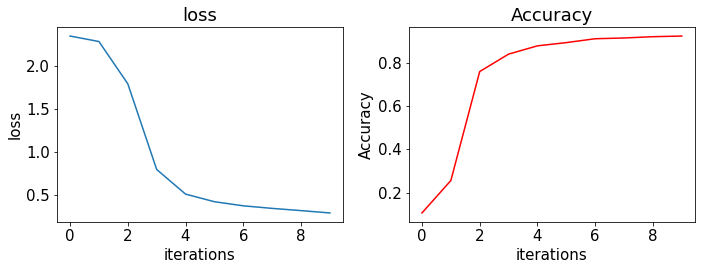

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1, 2, 1)   #1行２列の１番目
ax1.plot(cnn2d.loss_list)
ax1.set_title('loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')

ax2 = fig.add_subplot(1, 2, 2)   #１行２列の２番目
ax2.plot(cnn2d.acc_list, color='red')
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()



## 【問題10】出力サイズとパラメータ数の計算
---
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.

    入力サイズ : 144×144, 3チャンネル
    フィルタサイズ : 3×3, 6チャンネル
    ストライド : 1
    パディング : なし


2.

    入力サイズ : 60×60, 24チャンネル
    フィルタサイズ : 3×3, 48チャンネル
    ストライド　: 1
    パディング : なし


3.

    入力サイズ : 20×20, 10チャンネル
    フィルタサイズ: 3×3, 20チャンネル
    ストライド : 2
    パディング : なし


＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

## 解答

出力サイズ：
OH = (H + 2P - FH)/S + 1
OW = (W + 2P - FW)/S + 1

１  
出力サイズ：(FN, OH, OW) = 6, 142, 142)  
OH = (144 + 0 -3)/1 + 1 = 142  
OW = (144 + 0 -3)/1 + 1 = 142  
  
パラメータ：　w : (FN, C, FH, FW) = (6, 3, 3, 3) = 162
             b : (FN, 1, 1) = 6
             
２  
出力サイズ：(FN, OH, OW) = 48, 58, 58)  
OH = (60 + 0 -3)/1 + 1 = 58  
OW = (60 + 0 -3)/1 + 1 = 58  

パラメータ：　w : (FN, C, FH, FW) = (48, 24, 3, 3) = 10368  
             b : (FN, 1, 1) = 48  
             
      
３  
出力サイズ：(FN, OH, OW) = 20, 9, 9)  
OH = (20 + 0 -3)/2 + 1 = 9.5 => 9  
OW = (20 + 0 -3)/2 + 1 = 9.5 => 9  
  
パラメータ：　w : (FN, C, FH, FW) = (20, 10, 3, 3) = 1800  
             b : (FN, 1, 1) = 20  